#Burgers 1D Solved by PINNS

In [30]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn

## Burgers 1D Equation

The one-dimensional Burgers equation is a fundamental partial differential equation given by:

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2 u}{\partial x^2}$$

Where:
- **u(x,t)** is the velocity field
- **ν (nu)** is the kinematic viscosity coefficient
- **x** is the spatial coordinate
- **t** is the temporal coordinate

The equation combines:
- **Convection term**: $u\frac{\partial u}{\partial x}$ (nonlinear)
- **Diffusion term**: $\nu\frac{\partial^2 u}{\partial x^2}$ (viscous)

This is a classic nonlinear PDE used to test numerical methods and machine learning approaches like Physics-Informed Neural Networks (PINNs).


#Input x and t output velocity u

In [31]:
#Neural Network for PINNs

class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,40),
            nn.Tanh(),
            nn.Linear(40,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )
    #Forward pass
    def forward(self, x):
        out = self.net(x)
        return out

#Initial condition

#Data

In [32]:
class Net:
    def __init__(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = NN().to(device)

        #Computational domain (Mesh)
        self.h =0.1 # step size of x
        self.k = 0.1 # step size of t
        #Steps

        x = torch.arange(-1,1+self.h,self.h)
        t = torch.arange(0, 1+self.k, self.k)# time cannot be negative

        #Creating meshgrid

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        #Training data bOundary conditions
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T # u(-1,t) = 0)
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T # u(1,t) = 0)

        #Initial condition
        ic = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T 

        #concatenate all training data

        self.X_train = torch.cat([bc1, bc2, ic])

        #y value
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi*ic[:,0]) # u(x,0) = -sin(pi*x) to start is negative in x
        # concatenate all y values
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        #increase dimension unsing unsqueeze
        self.y_train = self.y_train.unsqueeze(1)

        #Move to device
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        #Optimizer
        self.adam = torch.optim.Adam(self.model.parameters())
        #Limited memory Bryson-Fletcher-Goldfarb-Shanno (L-BFGS) optimizer to test and compare best parameters

        self.optimizer = torch.optim.LBFGS(self.model.parameters(), 
                                           lr = 1.0,
                                           max_iter=50000,
                                           max_eval = 50000,
                                           history_size =50,
                                           tolerance_grad = 1e-05,
                                           tolerance_change = 1.0 * np.finfo(float).eps,
                                           line_search_fn = "strong_wolfe"
        )   

        #Loss function
         
        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    #Loss function
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        #Physics loss
        #calculation u

        u = self.model(self.X)

        du_dx = torch.autograd.grad(u, self.X, 
                                    grad_outputs=torch.ones_like(u),
                                    create_graph=True,
                                    retain_graph=True)[0]
        
        
        du_dt = du_dx[:,1]
        du_dx = du_dx[:,0]

        du_dxx = torch.autograd.grad(du_dx, self.X, 
                                    grad_outputs=torch.ones_like(du_dx),
                                    create_graph=True,
                                    retain_graph=True)[0]
        du_dxx = du_dxx[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01)/(math.pi) * du_dxx)
        loss = loss_data + loss_pde
        loss.backward()
        if self.iter % 100 ==0:
            print(f"Iteration {self.iter}, Loss: {loss.item()}, Data Loss: {loss_data.item()}, PDE Loss: {loss_pde.item()}")
        self.iter +=1
        return loss
    #Training function
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    #Evaluation function
    def eval_(self):
        self.model.eval()
        

In [33]:
#Training the model
net = Net()
net.train()


Iteration 100, Loss: 0.19193358719348907, Data Loss: 0.1878489851951599, PDE Loss: 0.00408459547907114
Iteration 200, Loss: 0.10178357362747192, Data Loss: 0.0723603367805481, PDE Loss: 0.029423236846923828
Iteration 300, Loss: 0.08773116767406464, Data Loss: 0.06338641792535782, PDE Loss: 0.02434474602341652
Iteration 400, Loss: 0.07661344856023788, Data Loss: 0.05494622886180878, PDE Loss: 0.02166721783578396
Iteration 500, Loss: 0.06735414266586304, Data Loss: 0.04777851328253746, PDE Loss: 0.019575627520680428
Iteration 600, Loss: 0.05610090494155884, Data Loss: 0.038705963641405106, PDE Loss: 0.017394941300153732
Iteration 700, Loss: 0.03934914246201515, Data Loss: 0.0261580441147089, PDE Loss: 0.013191097415983677
Iteration 800, Loss: 0.026496749371290207, Data Loss: 0.015877170488238335, PDE Loss: 0.010619578883051872
Iteration 900, Loss: 0.016122320666909218, Data Loss: 0.009676353074610233, PDE Loss: 0.006445967126637697
Iteration 1000, Loss: 0.01202264055609703, Data Loss: 0.

In [34]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

#testing

In [35]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)
print(X.shape)


torch.Size([20000, 2])


In [36]:
print(X)

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]])


In [37]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [45]:
print(f"shape of y_pred: {y_pred.shape}")
y_pred

shape of y_pred: (200, 100)


array([[-1.09493732e-04, -1.14902854e-04, -9.86605883e-05, ...,
         8.83191824e-05,  1.15856528e-04,  1.44183636e-04],
       [ 3.17669362e-02,  3.07723135e-02,  2.98546106e-02, ...,
         7.80397654e-03,  7.76846707e-03,  7.73519278e-03],
       [ 6.35114610e-02,  6.15411550e-02,  5.96995056e-02, ...,
         1.55206323e-02,  1.54224038e-02,  1.53270066e-02],
       ...,
       [-9.36277956e-02, -9.07757431e-02, -8.81047696e-02, ...,
        -2.30343044e-02, -2.28388608e-02, -2.26467997e-02],
       [-6.24700636e-02, -6.05622530e-02, -5.87849170e-02, ...,
        -1.52102858e-02, -1.50725693e-02, -1.49374902e-02],
       [-3.13062668e-02, -3.03437859e-02, -2.94631422e-02, ...,
        -7.38234818e-03, -7.30241835e-03, -7.22454488e-03]], dtype=float32)

In [39]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

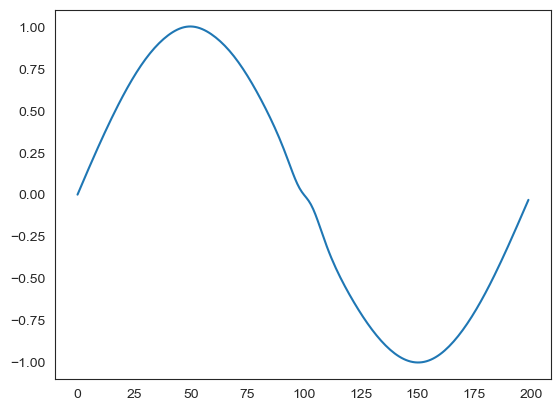

In [40]:
plt.plot(y_pred[:,0])

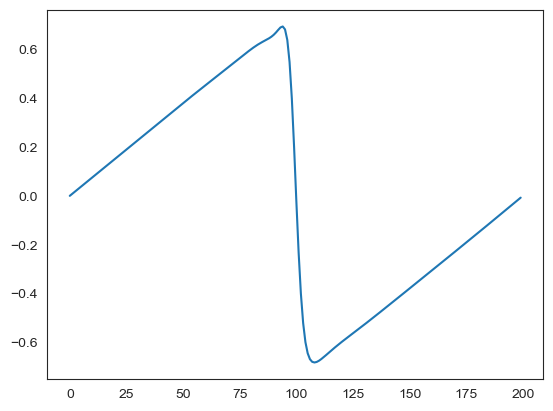

In [41]:
plt.plot(y_pred[:,-1])

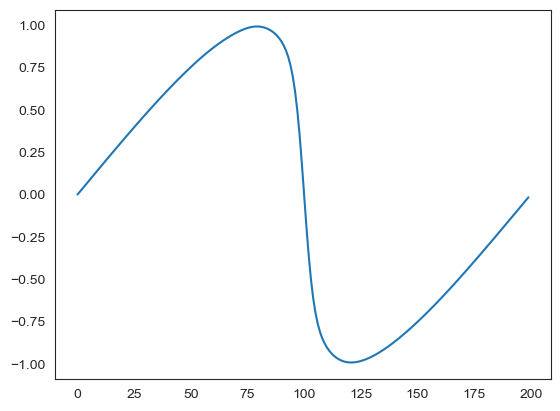

In [42]:
plt.plot(y_pred[:,30])

tensor([-1.0000e+00, -9.0000e-01, -8.0000e-01, -7.0000e-01, -6.0000e-01,
        -5.0000e-01, -4.0000e-01, -3.0000e-01, -2.0000e-01, -1.0000e-01,
        -2.9802e-09,  1.0000e-01,  2.0000e-01,  3.0000e-01,  4.0000e-01,
         5.0000e-01,  6.0000e-01,  7.0000e-01,  8.0000e-01,  9.0000e-01,
         1.0000e+00])
tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])
tensor([[-1.0000e+00,  0.0000e+00],
        [-1.0000e+00,  1.0000e-01],
        [-1.0000e+00,  2.0000e-01],
        [-1.0000e+00,  3.0000e-01],
        [-1.0000e+00,  4.0000e-01],
        [-1.0000e+00,  5.0000e-01],
        [-1.0000e+00,  6.0000e-01],
        [-1.0000e+00,  7.0000e-01],
        [-1.0000e+00,  8.0000e-01],
        [-1.0000e+00,  9.0000e-01],
        [-1.0000e+00,  1.0000e+00],
        [-9.0000e-01,  0.0000e+00],
        [-9.0000e-01,  1.0000e-01],
        [-9.0000e-01,  2.0000e-01],
        [-9.0000e-01,  3.0000e-01],
        [-9.0000e-01,  4.0000e-01],
     

Text(0.5, 0, 'x')

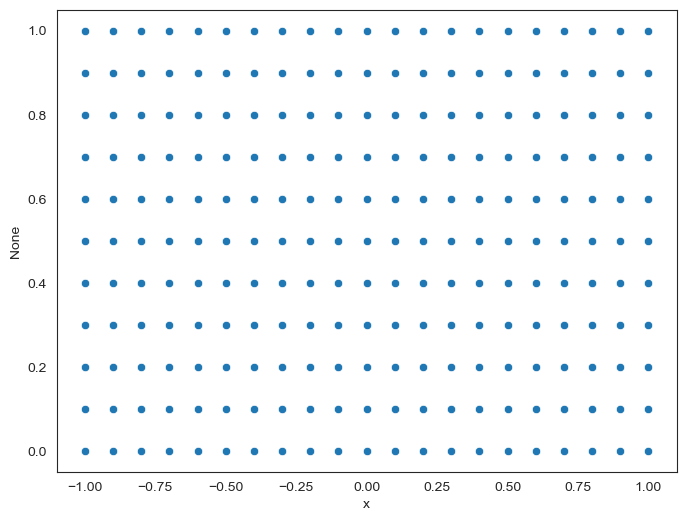

In [43]:
#print the meshgrid
x_tes = torch.arange(-1,1+0.1,0.1)
t_tes= torch.arange(0, 1+0.1, 0.1)

print(x_tes)
print(t_tes)

X_tes = torch.stack(torch.meshgrid(x_tes,t_tes)).reshape(2,-1).T
print(X_tes)

#visualize the meshgrid
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tes[:,0], y=X_tes[:,1]) #x,t
plt.xlabel('x')


In [44]:
#Boundary condition print
bc1_test = torch.stack(torch.meshgrid(x_tes[0],t_tes)).reshape(2,-1).T
print("Boundary condition at x=-1:", bc1_test)
print("\n")
bc2_test = torch.stack(torch.meshgrid(x_tes[-1],t_tes)).reshape(2,-1).T
print("Boundary condition at x=1:", bc2_test)

print("\n")

ic_test = torch.stack(torch.meshgrid(x_tes,t_tes[0])).reshape(2,-1).T
print("Initial condition at t=0:", ic_test)


Boundary condition at x=-1: tensor([[-1.0000,  0.0000],
        [-1.0000,  0.1000],
        [-1.0000,  0.2000],
        [-1.0000,  0.3000],
        [-1.0000,  0.4000],
        [-1.0000,  0.5000],
        [-1.0000,  0.6000],
        [-1.0000,  0.7000],
        [-1.0000,  0.8000],
        [-1.0000,  0.9000],
        [-1.0000,  1.0000]])


Boundary condition at x=1: tensor([[1.0000, 0.0000],
        [1.0000, 0.1000],
        [1.0000, 0.2000],
        [1.0000, 0.3000],
        [1.0000, 0.4000],
        [1.0000, 0.5000],
        [1.0000, 0.6000],
        [1.0000, 0.7000],
        [1.0000, 0.8000],
        [1.0000, 0.9000],
        [1.0000, 1.0000]])


Initial condition at t=0: tensor([[-1.0000e+00,  0.0000e+00],
        [-9.0000e-01,  0.0000e+00],
        [-8.0000e-01,  0.0000e+00],
        [-7.0000e-01,  0.0000e+00],
        [-6.0000e-01,  0.0000e+00],
        [-5.0000e-01,  0.0000e+00],
        [-4.0000e-01,  0.0000e+00],
        [-3.0000e-01,  0.0000e+00],
        [-2.0000e-01,  0.0000e+